In [1]:
library(astsa)
options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas
library(dplyr)
#install.packages("xts")                      # Install & load xts package
library("xts")
library(lubridate)
library(forecast) 
#install.packages("fGarch")
library(fGarch)
#install.packages("rugarch")
library(rugarch)
library(tseries)
#install.packages("fDMA")
library(fDMA)
#install.packages("dynlm")
library(dynlm)
#install.packages("FinTS")
library(FinTS)




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'xts' was built under R version 3.6.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 3.6.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date


Warning message:
"package 'forecast' was built under R version 3.6.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'forecast'


The following object is masked from 'package:astsa':

    gas


Warning message:
"package 'fGarch' was built under R versi

# GOLD

In [2]:
df_gold = read.csv("gold_price_data.csv")
head(df_gold,15)
tail(df_gold)

,Date,Value
,<fct>,<dbl>
1,1970-01-01,35.2
2,1970-04-01,35.1
3,1970-07-01,35.4
4,1970-10-01,36.2
5,1971-01-01,37.4
6,1971-04-01,38.9
7,1971-07-01,40.1
8,1971-10-01,42.0
9,1972-01-03,43.5


,Date,Value
,<fct>,<dbl>
10782,2020-03-06,1683.65
10783,2020-03-09,1672.50
10784,2020-03-10,1655.70
10785,2020-03-11,1653.75
10786,2020-03-12,1570.70
10787,2020-03-13,1562.80


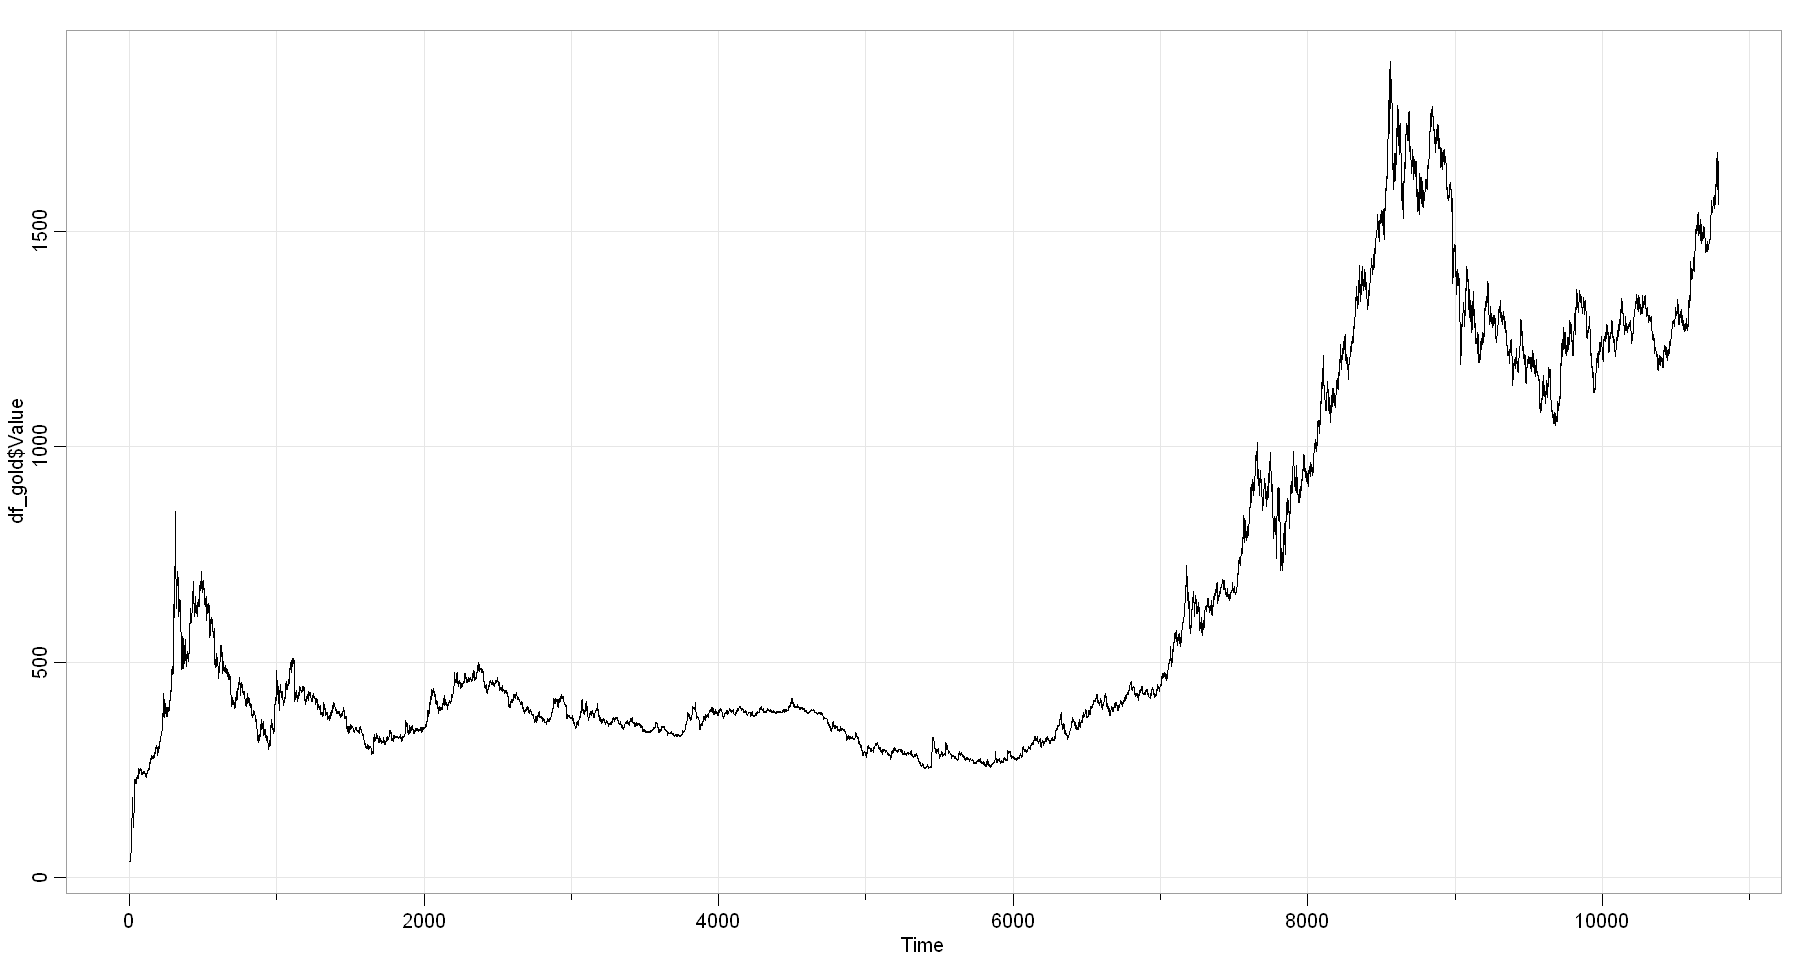

In [3]:
tsplot(df_gold$Value)

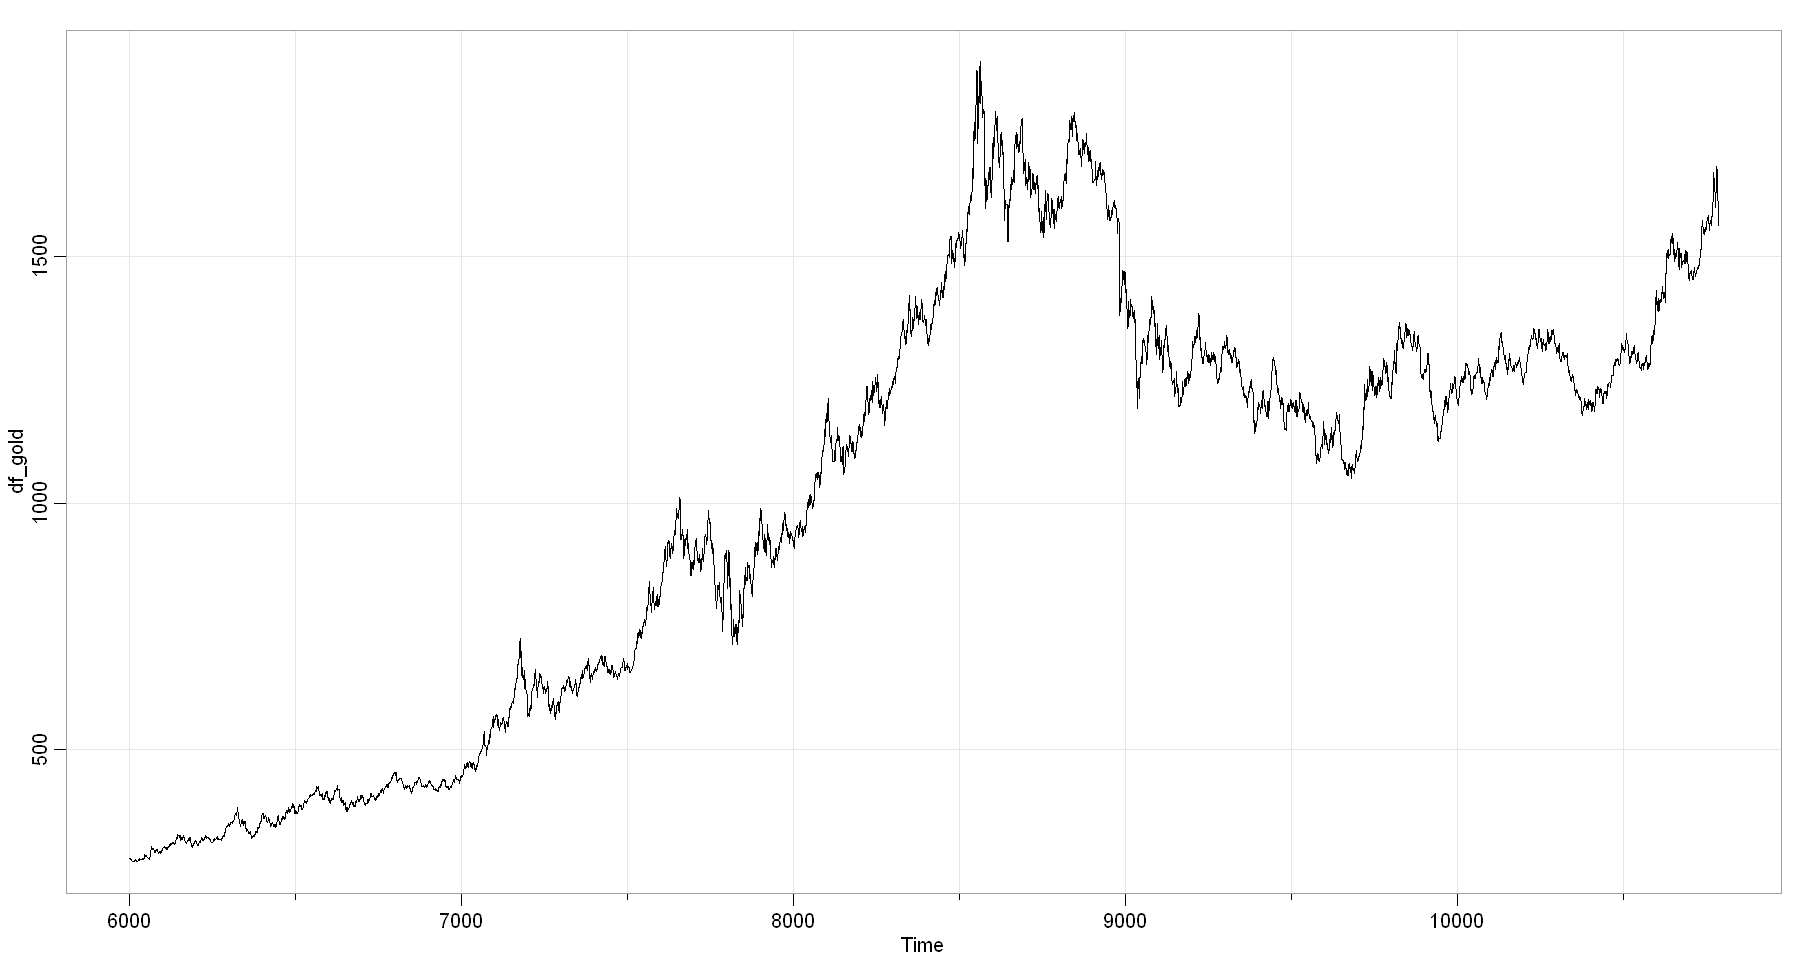

In [4]:
#Reducimos los datos dado que son muchos ya que la señal tienen dos comportamientos diferentes. Nos quedamos con el mas actual que es a partir del dato 6000.
df_gold = ts(df_gold$Value[6000:length(df_gold$Value)],start = 6000)
tsplot(df_gold)

In [5]:
#Aplico shapiro test para normalidad
shapiro.test(df_gold)
#Nos da que es significativo por lo que rechazo la hipotesis nula de que los datos tiene varianza normal.



	Shapiro-Wilk normality test

data:  df_gold
W = 0.92626, p-value < 2.2e-16


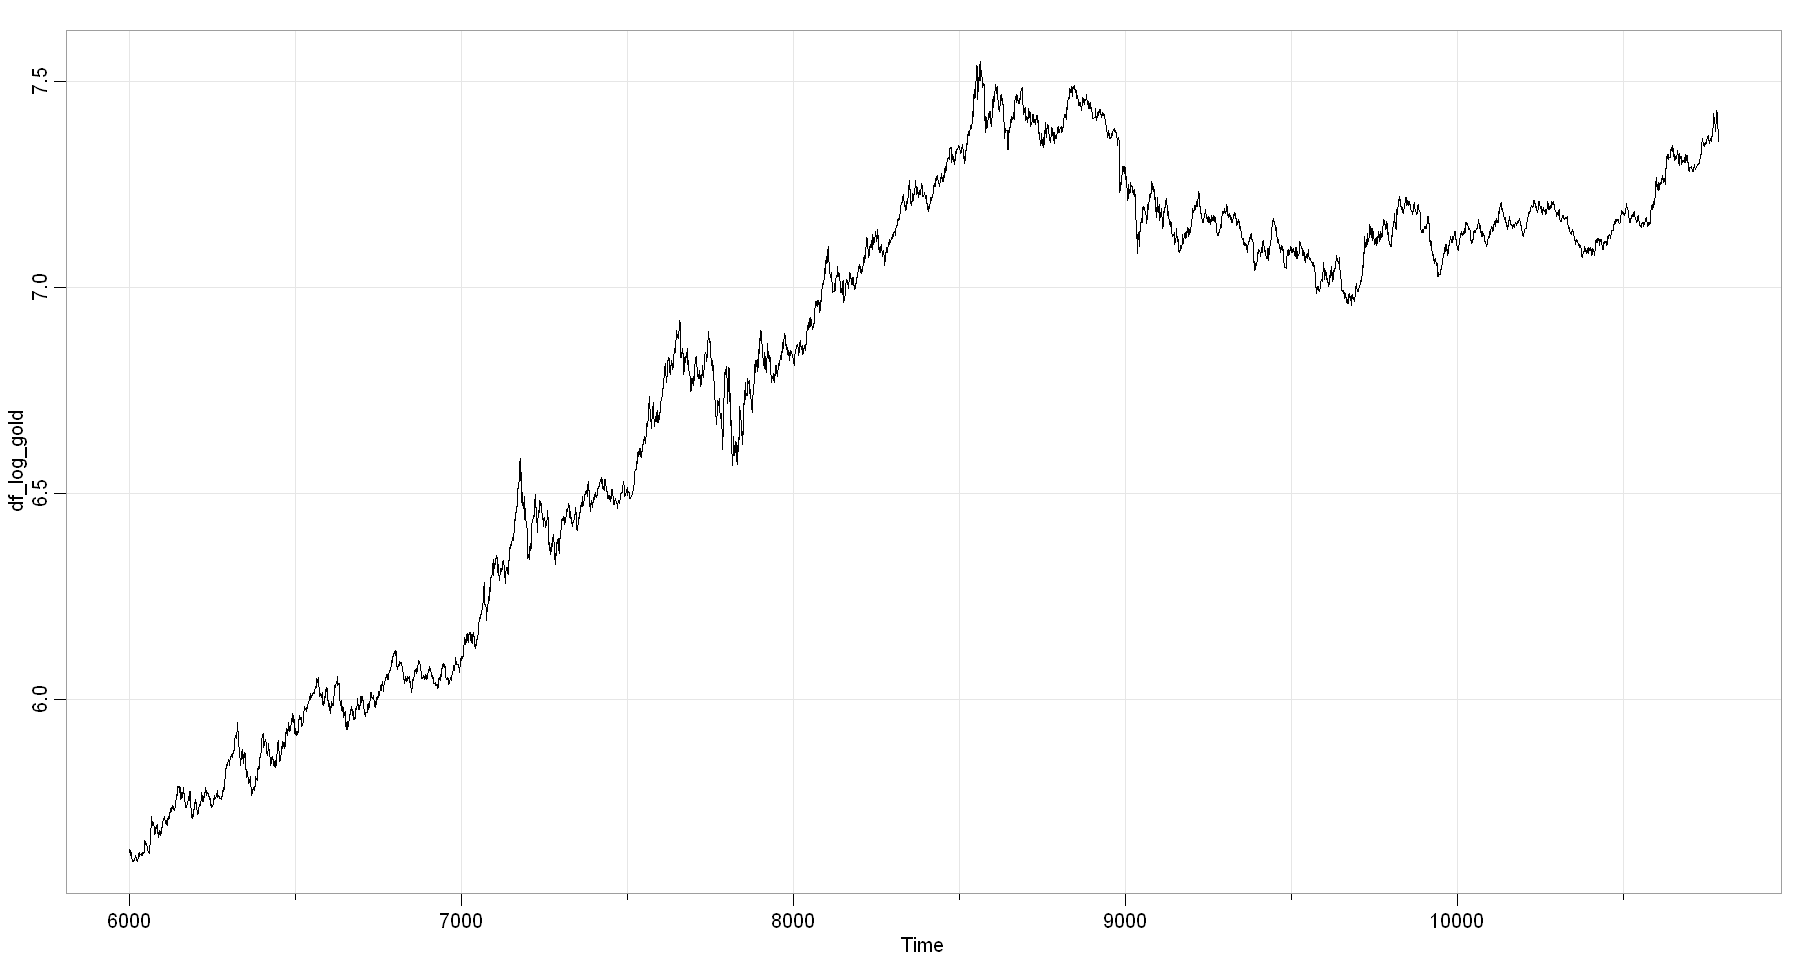

In [6]:
df_log_gold = log(df_gold)
tsplot(df_log_gold)

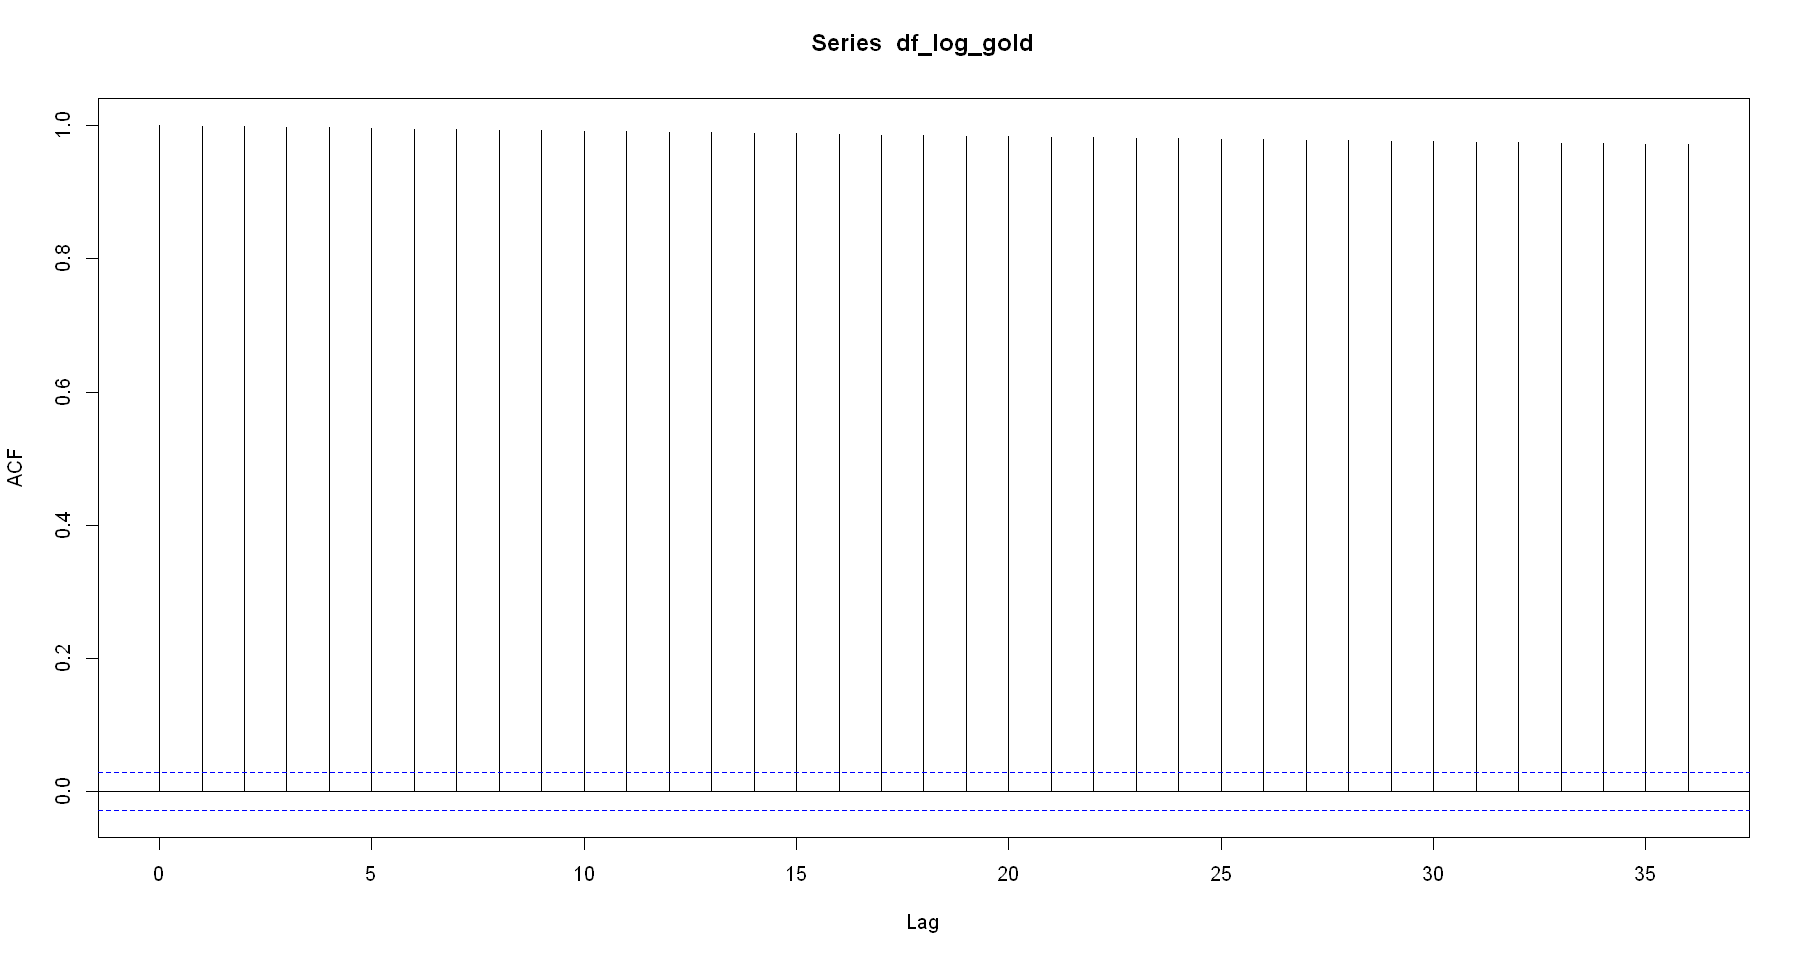

In [7]:
acf(df_log_gold)
#A simple vista ya no es estacionaria , el acf nos demuestra lo mismo que vemos en la grafica del log de gold.

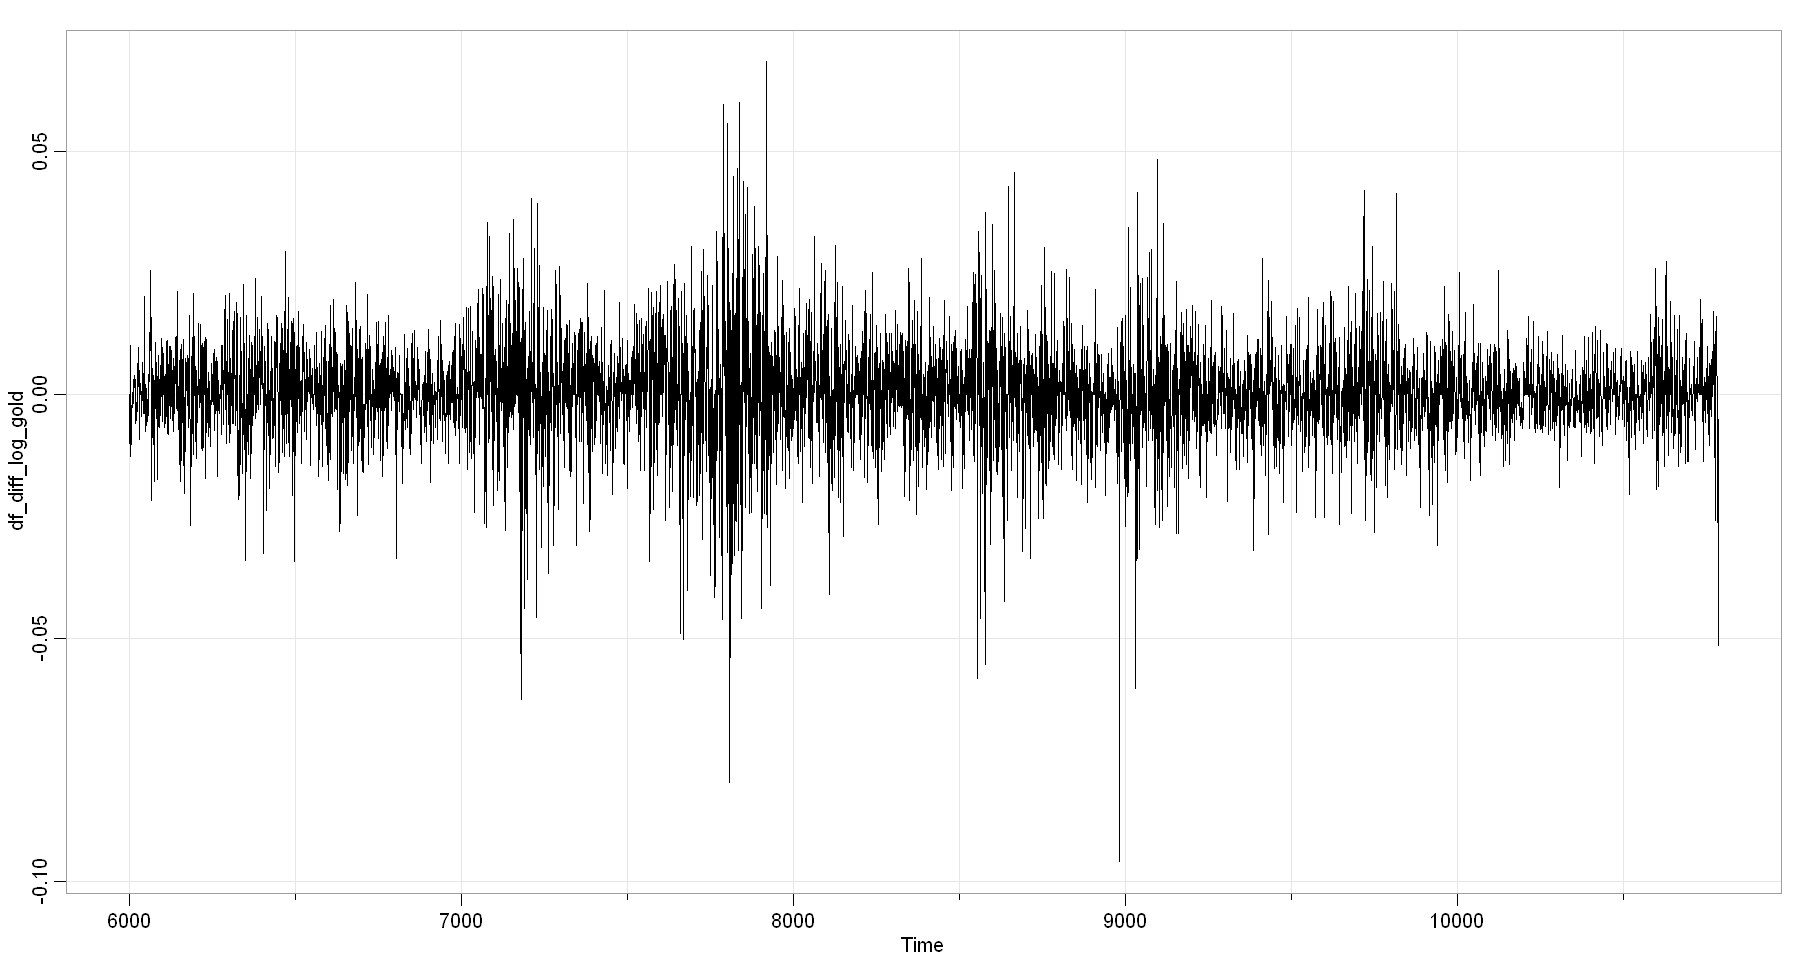

In [8]:
#Como crece año a año aplicamos la diferencia de logaritmos para ver el retorno o tasa de crecimiento.
#Adicionalmente esto permite centrar en cero utilizando esta tecnica en lugar de quitar la tendencia con una recta que no se observa claramente.
#FALTA: Agregar grafico con recta de tendencia para mostrar que no es clara la recta a quitar.
df_diff_log_gold = diff(log(df_gold))
tsplot(df_diff_log_gold)

Observamos que la señal continua teniendo picos marcados (alta varianza) por lo tanto encontramos que es estacionaria en la media con alta varianza. DUDA ANDRES

In [9]:
#Separo train y test en el diff
#Como vamos a intentar predecir el comportamiento de la señal separamos un conjunto de train y test.

train = ts(df_diff_log_gold[0:4740],start = 6001)
test = ts(df_diff_log_gold[4740:length(df_diff_log_gold)],start = 10751)


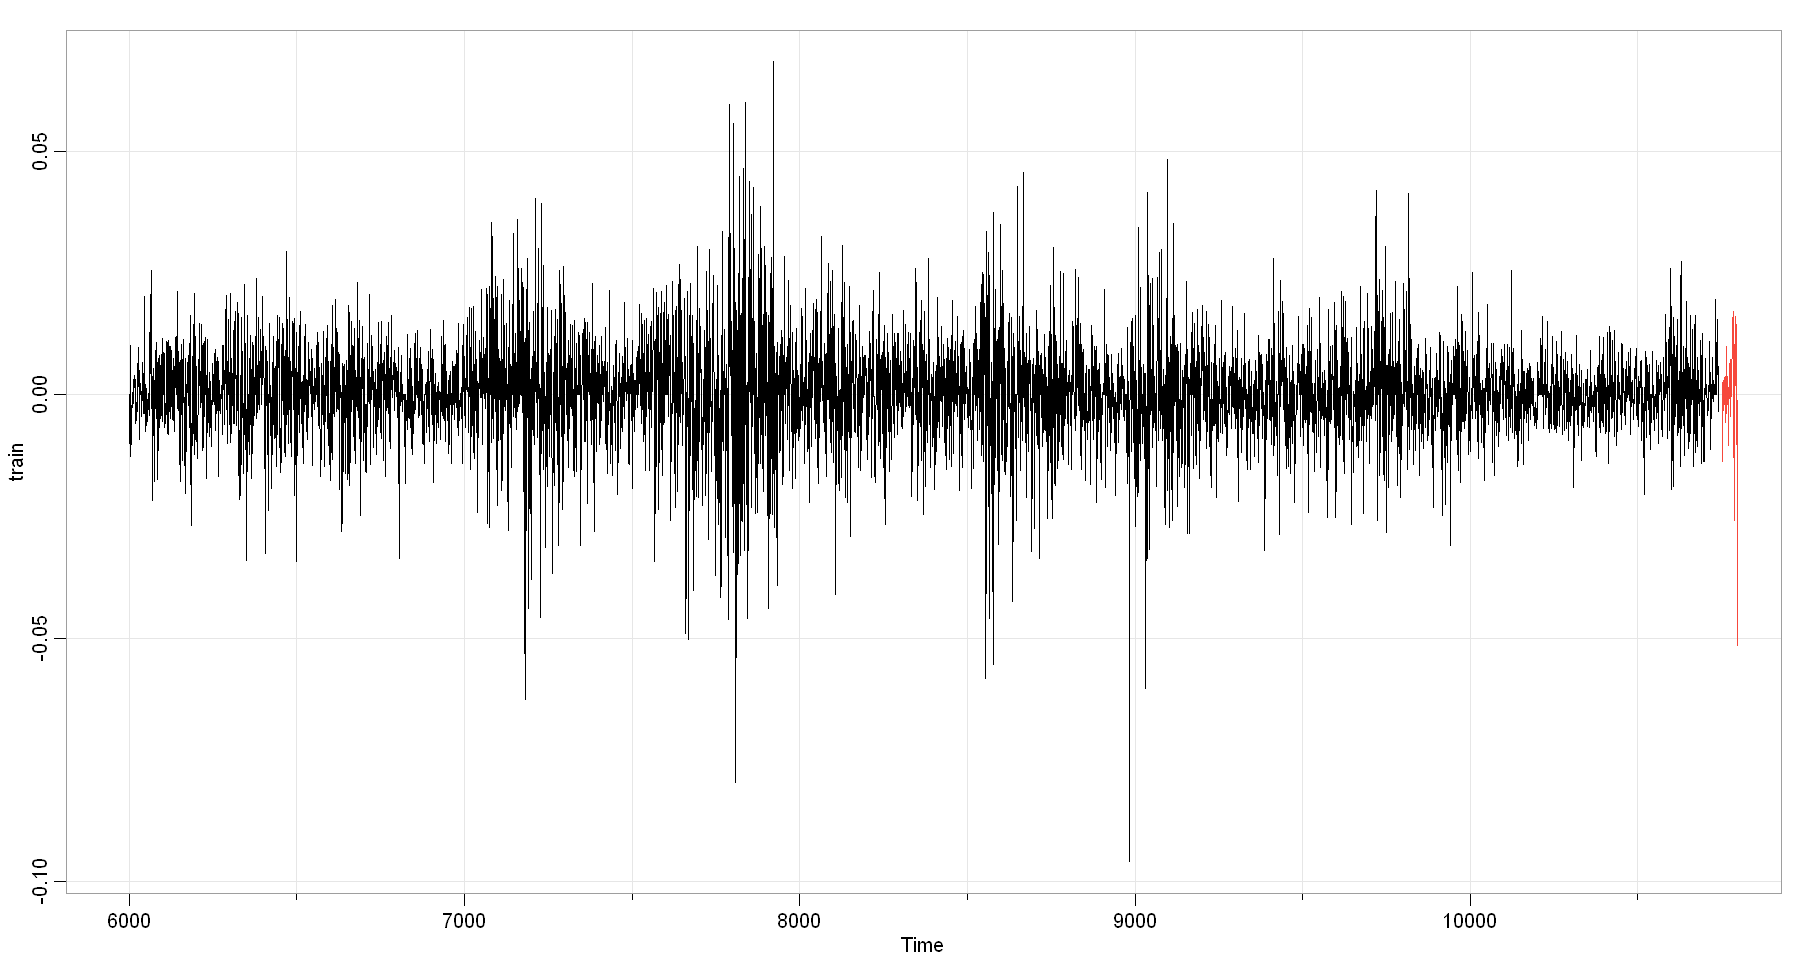

In [10]:
tsplot(train)
lines(test,col=2)

In [11]:
#APlicamos test para confirmar que es estacionario
adf.test(train)
#Rechazamos la hipotesis nula (que no es estacionario) al observar un p-value menor que 0,05 (significativo)

Warning message in adf.test(train):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train
Dickey-Fuller = -16.863, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


ACF,0,-0.01,0.01,0.01,0,-0.03,-0.01,-0.01,0.02,-0.02,...,0.02,-0.02,-0.01,-0.04,-0.02,0.01,0.02,-0.01,0.01,-0.01
PACF,0,-0.01,0.01,0.01,0,-0.03,-0.01,-0.01,0.02,-0.02,...,0.02,-0.01,-0.01,-0.04,-0.01,0.01,0.01,0.00,0.00,-0.01


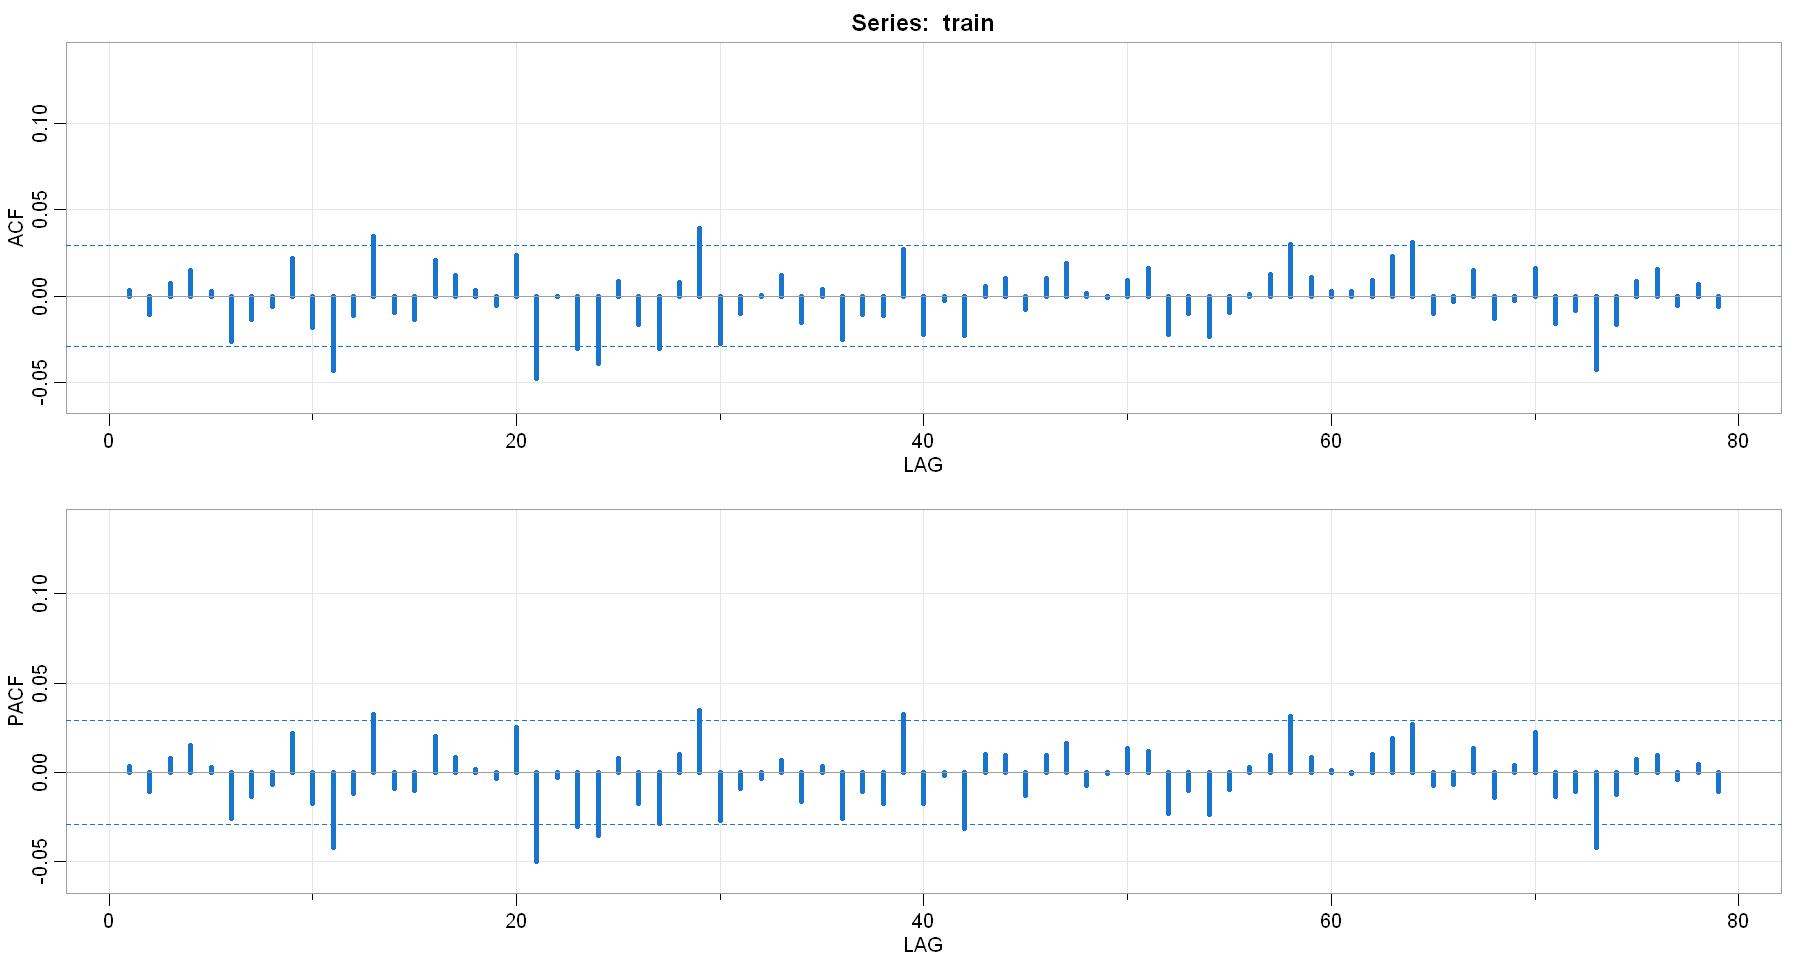

In [12]:
acf2(train, lwd=4, col=4)
#No encontramos ningun componente media movil el ACF , ni autorregresivo en el PACF.
#Si bien en el PACF encontramos algunas barras muy pequeñas fuera del intervalo de confianza entendemos que son parte del 5% de error.
#Ya que anteriormente habiamos aplicado diff y ahora nos da ruido blanco es que estamos en presencia de un paseo al azar con deriva.

In [13]:
#El auto arima de R concluye lo mismo que nosotros
auto.arima(train)

Series: train 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
       mean
      4e-04
s.e.  2e-04

sigma^2 estimated as 0.0001165:  log likelihood=14741.24
AIC=-29478.47   AICc=-29478.47   BIC=-29465.54

Descartamos la posibilidad de utilizar un modelo ARIMA ya que como vimos anteriormente estamos en presencia de una señal que si bien estacionaria en la media, no tiene varianza constante y esto contradice un supuesto fundamental para la apliciacion de los modelos ARIMA que deben tener estacionalidad en la media y varianza constante.

A continuacion, analizaremos el comportamiento de la varianza.

# Analisis de varianza

[1] 0.01079364

[1] 0.0001165026

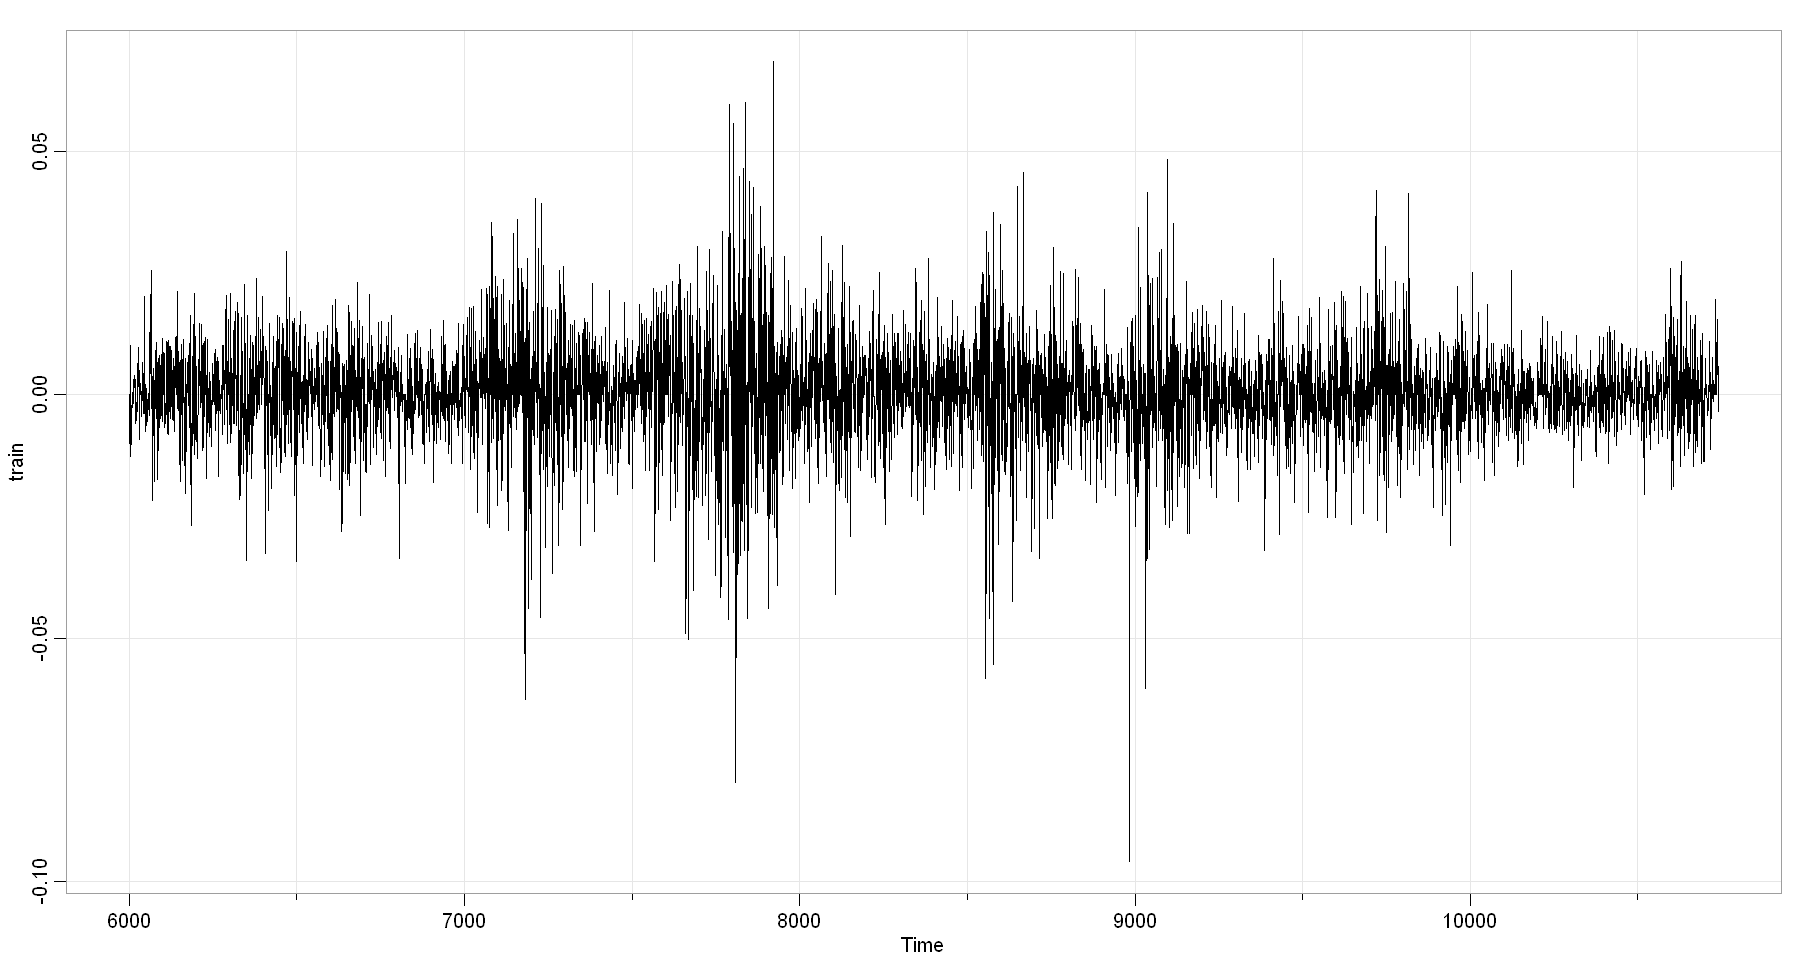

In [14]:
sd(train)
var(train)
tsplot(train)

In [15]:
vent<- 50
vent2<- vent-1


varianza=c()
for(i in vent:length(train))
    {f=var(train[(i-vent2):i])
    varianza[i]=(f)}



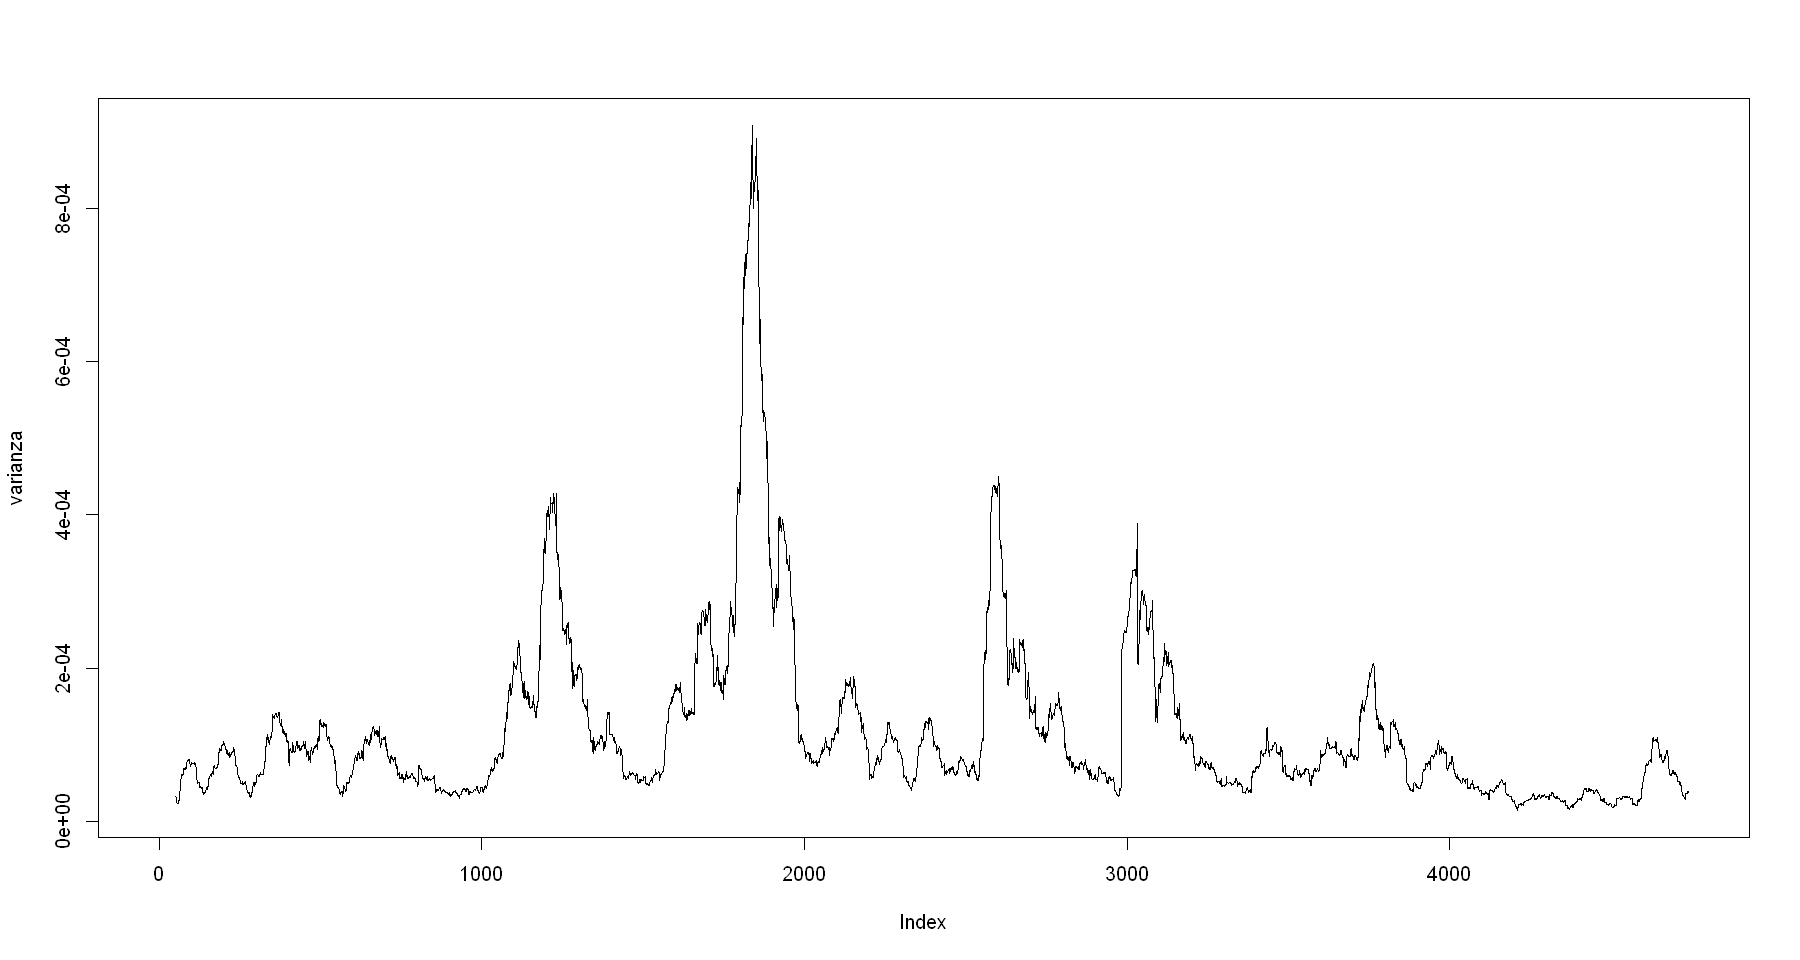

In [16]:
plot(varianza,type="l")

Se puede observar como mirando en distintas ventanas de tiempo la varianza no es constante.

In [17]:
y<-train

In [18]:
STDM=c()
for(i in vent:length(y))
    {f=sd(y[(i-vent2):i])
    STDM[i]=(f)}
#STDM
STDM2<-STDM*2

In [19]:
MM=c()
for(i in vent:length(y))
    {f=mean(y[(i-vent2):i])
    MM[i]=(f)}

In [20]:
#desviacion típica

#sd(na.omit(y))
#2*sd(na.omit(y))

sd1= MM + STDM
#sd1
sd11= MM-STDM
#sd11

In [21]:
sd2<-MM+STDM2
sd22<-MM-STDM2

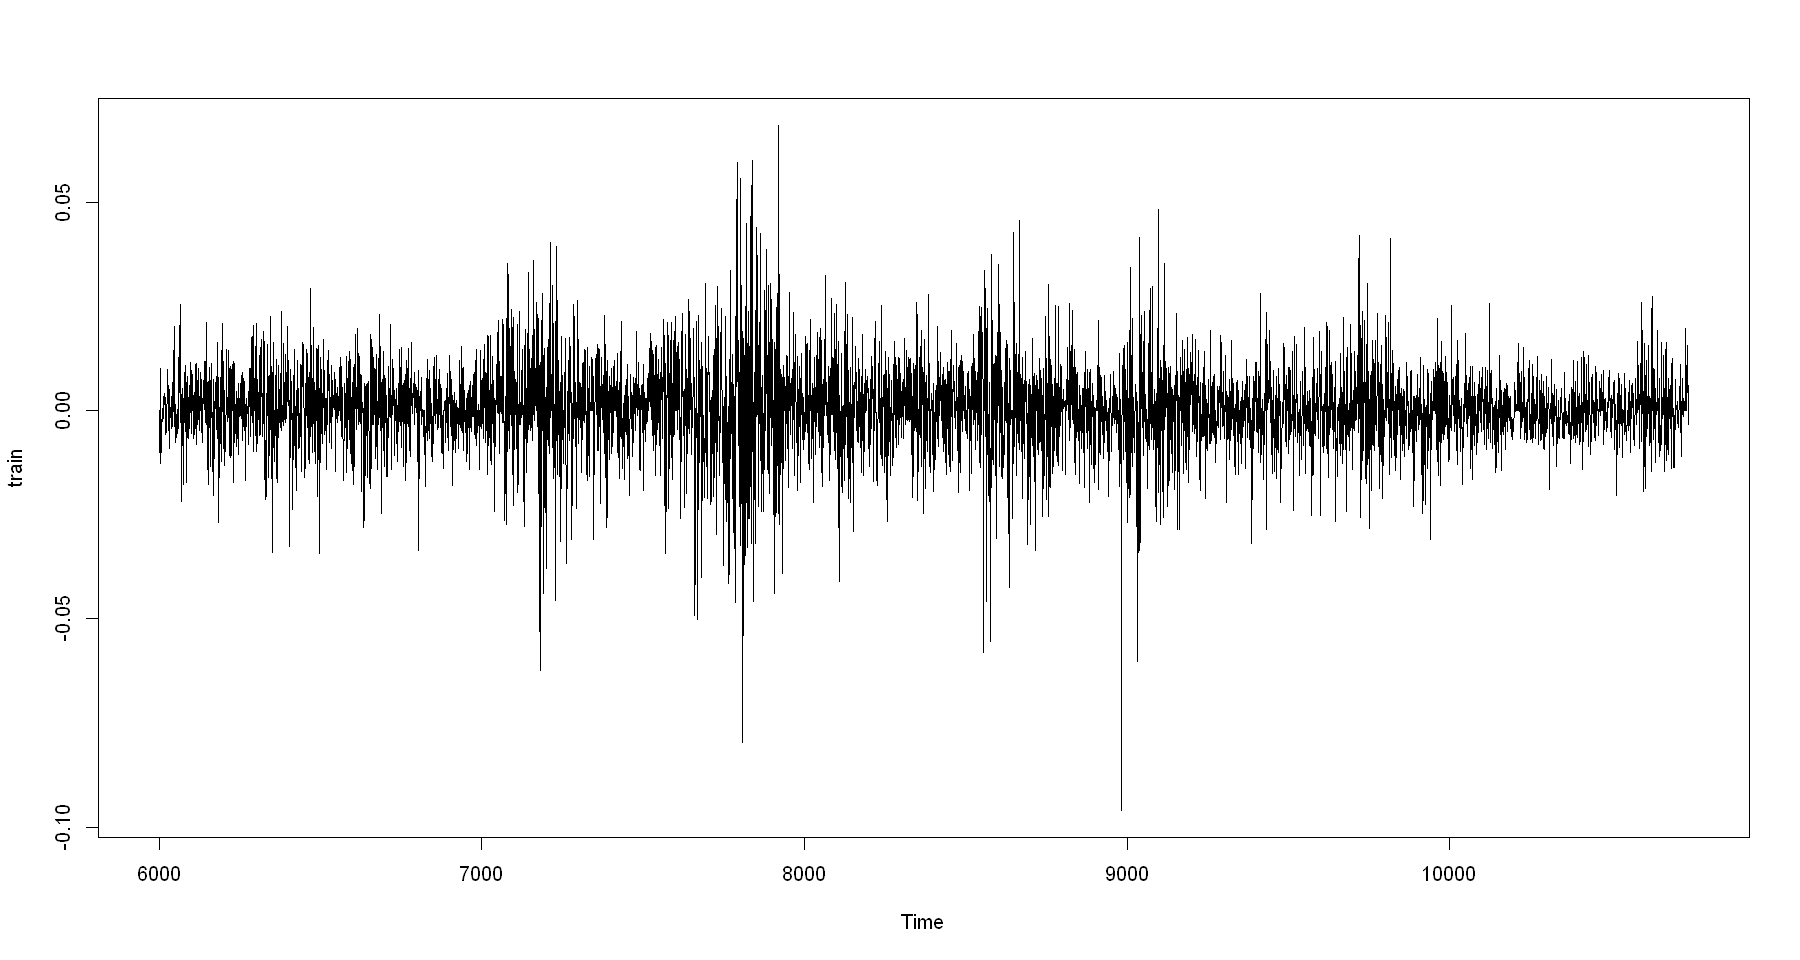

In [22]:
plot(train,type="l")
lines(MM, col="blue")
lines(sd11, col="green")
lines(sd1,col="green")
lines(sd2,col="red")
lines(sd22,col="red")

In [23]:
#Se muestra como la varianza no es constante.

#FALTA:NOI ESTAN FUNCIONANDO LOS COLORES. EXPLICAR COLORES.

Debido a esto es que podemos pensar en la aplicacion de un modelo ARCH o GARCH. Vamos a confirmarlo a travez de un ARCH test.

Para saber si los residuos tienen alta varianza vamos a aplicar una prueba ARCH (ARCH test).

FALTA ESCRIBIR LA HIPOTESIS NULA

La prueba de efecto ARCH es una prueba de ruido blanco para la serie de tiempo al cuadrado, en nuestro caso serian la señal al cuadrado. Lo que en otras palabras es la investigacion de un orden superior no lineal de autocorrelacion.

Por ende una prueba ARCH significativa nos indica una volatilidad variable en el tiempo.



In [24]:
#Hacemos teste de aplicacion de arch
archtest = archtest(ts = as.vector(train))
archtest


	Engle's LM ARCH Test

data:  as.vector(train)
statistic = 38.623, lag = 1, p-value = 5.142e-10
alternative hypothesis: ARCH effects of order 1 are present


In [25]:
#Hacemos teste de aplicacion de archnde orden 2
archtest = archtest(ts = as.vector(train),lag = 2)
archtest


	Engle's LM ARCH Test

data:  as.vector(train)
statistic = 76.358, lag = 2, p-value < 2.2e-16
alternative hypothesis: ARCH effects of order 2 are present


In [26]:
#Hacemos teste de aplicacion de archnde orden 50
archtest = archtest(ts = as.vector(train),lag = 50)
archtest


	Engle's LM ARCH Test

data:  as.vector(train)
statistic = 536.42, lag = 50, p-value < 2.2e-16
alternative hypothesis: ARCH effects of order 50 are present


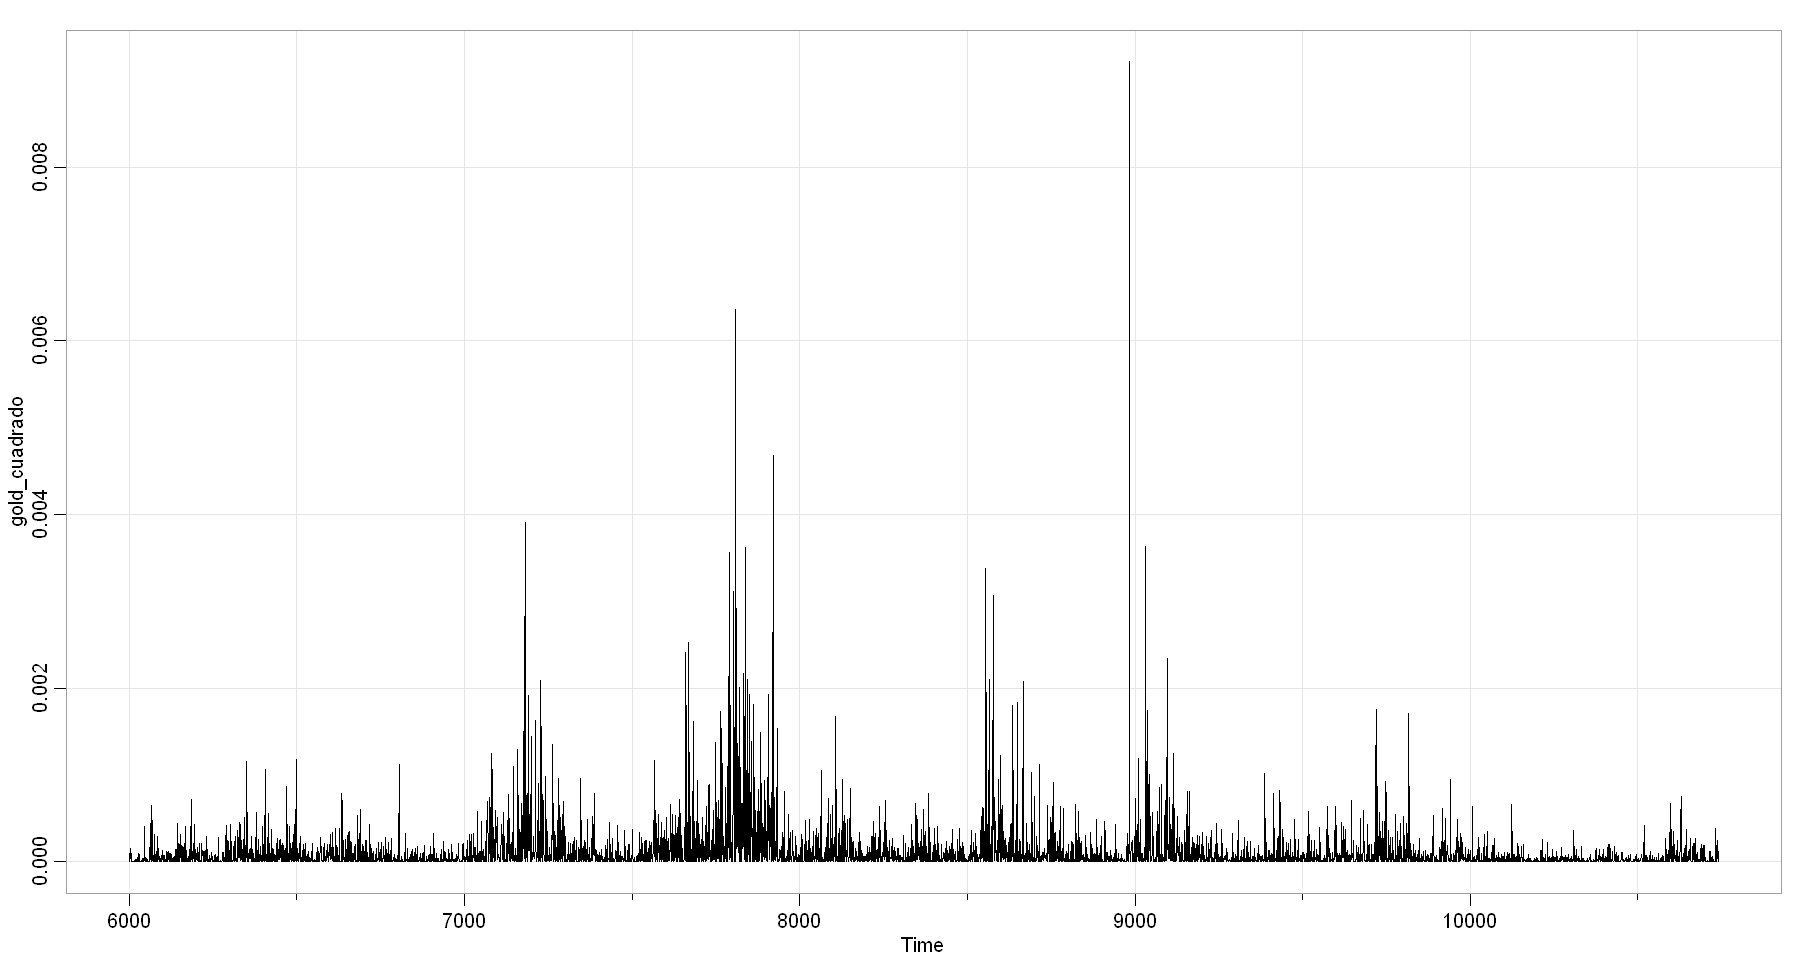

In [27]:
#Ya que estamos no estamos encontrando el orden a aplicar al modelo ARCH (unicamente encontramos que hay que aplicarlo)
gold_cuadrado = train^2
tsplot(gold_cuadrado)
#Se muestra como hay varianza es heterosedastica por que es muy variable en el tiempo.

## Orden ARCH

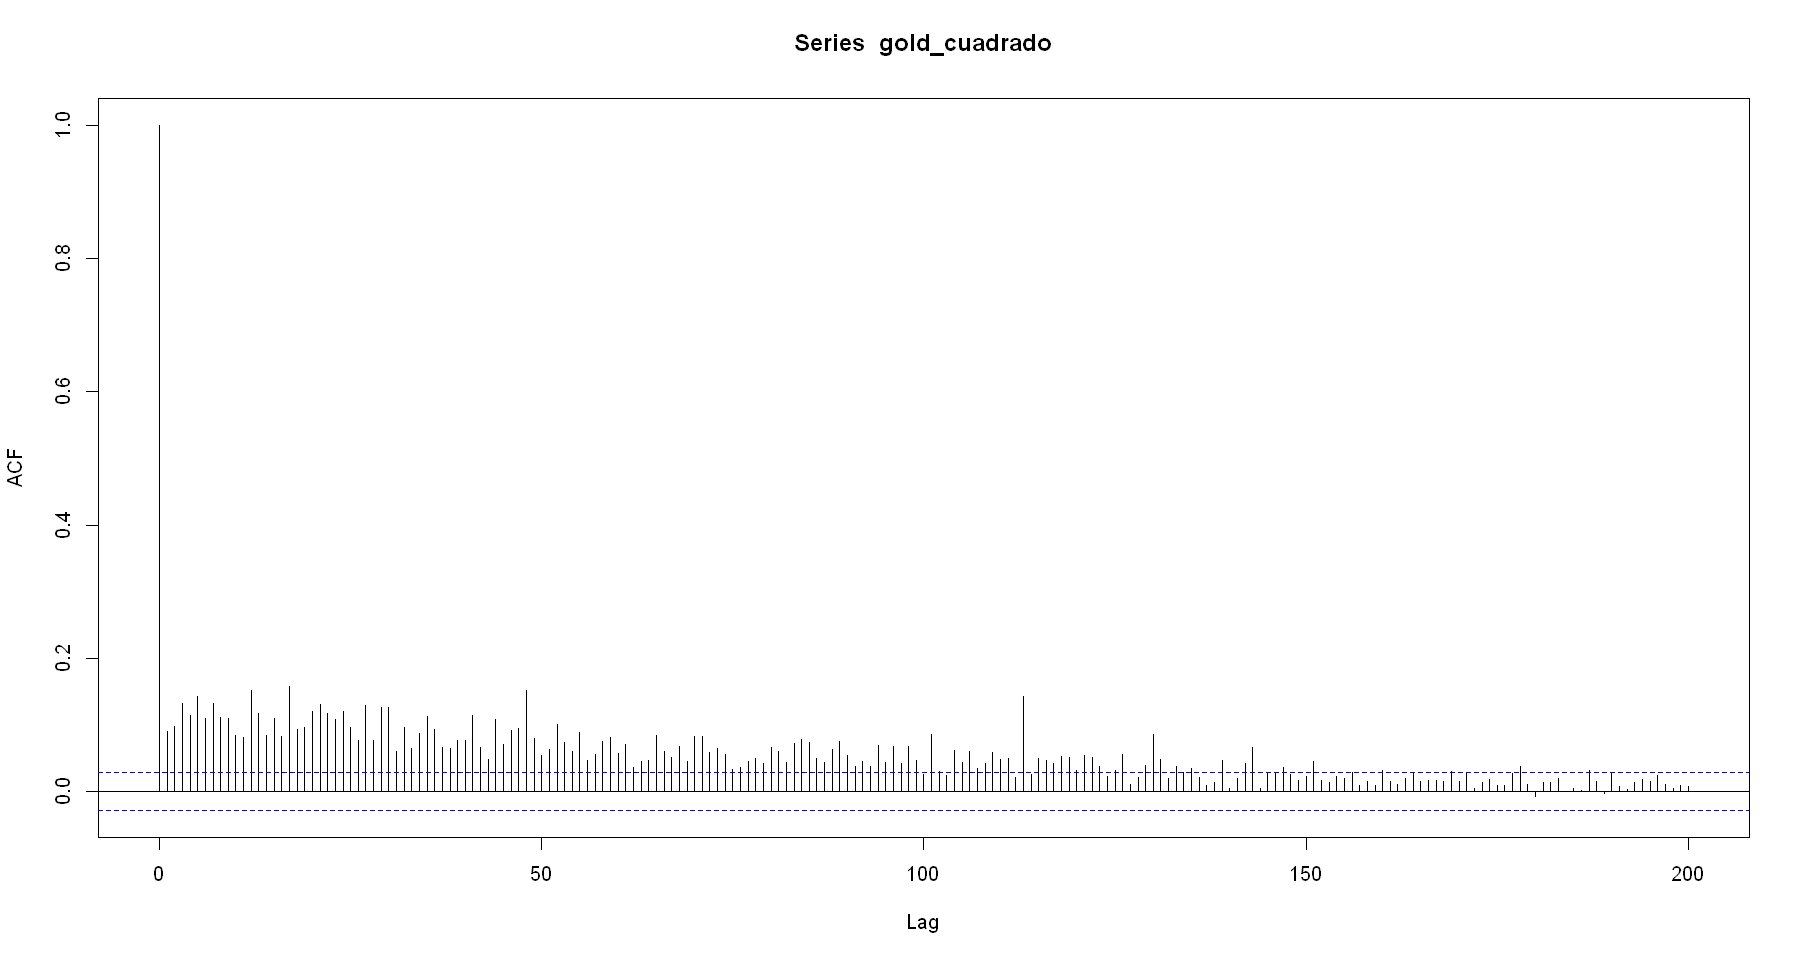

In [28]:
acf(gold_cuadrado,lag.max = 200)
#VEmos como el 

# Aplicamos GARCH

In [29]:
gold_garch12_spec <-  ugarchspec(variance.model = list(model="sGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(50,50)), # You can modify the order GARCH(m,s) here
                               #mean.model = list(armaOrder=c(1,2)), #Specify your ARMA model implying your model should be stationary.
                               mean.model = list(armaOrder = c(1, 1), include.mean = TRUE, archm = FALSE, archpow = 1, arfima = FALSE, external.regressors = NULL, archex = FALSE),
                                distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_garch12 <- ugarchfit(spec=gold_garch12_spec, 
                              data=train)


In [30]:
gold_garch12


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(50,50)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
         Estimate  Std. Error   t value Pr(>|t|)
mu       0.000321    0.000120  2.675443 0.007463
ar1     -0.871100    0.204996 -4.249341 0.000021
ma1      0.880004    0.198104  4.442122 0.000009
omega    0.000010    0.000004  2.399412 0.016421
alpha1   0.026338    0.009613  2.739752 0.006149
alpha2   0.009391    0.011472  0.818536 0.413051
alpha3   0.044298    0.008226  5.385000 0.000000
alpha4   0.060292    0.012481  4.830569 0.000001
alpha5   0.014857    0.008662  1.715081 0.086330
alpha6   0.028735    0.011418  2.516625 0.011848
alpha7   0.072635    0.015023  4.834764 0.000001
alpha8   0.013438    0.016735  0.802990 0.421980
alpha9   0.050296    0.008780  5.728335 0.000000
alp

In [31]:
#predict_gold12@forecast$sigmaFor # DUDA: Es el desvio standar ??

# egarch (1,1)

In [32]:
gold_egarch11_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(1,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(1,1)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch11 <- ugarchfit(spec=gold_egarch11_spec, 
                              data=train)

In [33]:
gold_egarch11


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000443    0.000131    3.3733 0.000743
ar1     0.586318    0.017995   32.5830 0.000000
ma1    -0.576016    0.018129  -31.7729 0.000000
omega  -0.057254    0.001400  -40.9076 0.000000
alpha1  0.007684    0.005120    1.5008 0.133404
beta1   0.993051    0.000120 8250.1400 0.000000
gamma1  0.098407    0.004451   22.1109 0.000000

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000443    0.000139    3.18255  0.00146
ar1     0.586318    0.006010   97.56482  0.00000
ma1    -0.576016    0.006166  -93.41330  0.00000
omega  -0.057254    0.002380  -24.05745  0.00000
alpha1  0.007684    0.014835    0.517

# egarch (1,2)

In [34]:
gold_egarch12_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(1,2)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(1,1)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch12 <- ugarchfit(spec=gold_egarch12_spec, 
                              data=train)

In [35]:
gold_egarch12


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,2)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000444    0.000128     3.4599  0.00054
ar1     0.587475    0.017905    32.8106  0.00000
ma1    -0.577164    0.018043   -31.9874  0.00000
omega  -0.056992    0.007462    -7.6382  0.00000
alpha1  0.007642    0.005138     1.4873  0.13693
beta1   0.999998    0.000014 69271.4036  0.00000
beta2  -0.006914    0.000909    -7.6096  0.00000
gamma1  0.097720    0.008881    11.0038  0.00000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000444    0.000132     3.35315 0.000799
ar1     0.587475    0.006137    95.72656 0.000000
ma1    -0.577164    0.006273   -92.00988 0.000000
omega  -0.056992    0.016

# EGARCH (2,1)

In [36]:
gold_egarch21_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(2,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(1,1)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch21 <- ugarchfit(spec=gold_egarch21_spec, 
                              data=train)

In [37]:
gold_egarch21


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(2,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000466    0.000125     3.7157 0.000203
ar1     0.677507    0.038563    17.5689 0.000000
ma1    -0.671268    0.038837   -17.2844 0.000000
omega  -0.063011    0.001143   -55.1517 0.000000
alpha1 -0.134700    0.010561   -12.7544 0.000000
alpha2  0.151373    0.011577    13.0749 0.000000
beta1   0.992461    0.000035 28007.4865 0.000000
gamma1  0.048972    0.026000     1.8835 0.059626
gamma2  0.048789    0.026701     1.8272 0.067666

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000466    0.000130    3.5707 0.000356
ar1     0.677507    0.005829  116.2289 0.000000
ma1    -0.671268    0.006156 -10

# EGARCH (3,1)

In [38]:
gold_egarch31_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(3,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(1,1)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch31 <- ugarchfit(spec=gold_egarch31_spec, 
                              data=train)

In [39]:
gold_egarch31


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(3,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000457    0.000117  3.8987e+00 0.000097
ar1     0.654896    0.016557  3.9555e+01 0.000000
ma1    -0.646433    0.016752 -3.8589e+01 0.000000
omega  -0.067883    0.001183 -5.7404e+01 0.000000
alpha1 -0.132553    0.015073 -8.7940e+00 0.000000
alpha2  0.112577    0.027206  4.1380e+00 0.000035
alpha3  0.039857    0.021699  1.8368e+00 0.066238
beta1   0.991914    0.000030  3.2904e+04 0.000000
gamma1  0.055189    0.021596  2.5555e+00 0.010604
gamma2  0.000646    0.039824  1.6227e-02 0.987053
gamma3  0.044638    0.030701  1.4539e+00 0.145964

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000457

# EGARCH (4,1)

In [40]:
gold_egarch41_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(4,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(1,1)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch41 <- ugarchfit(spec=gold_egarch41_spec, 
                              data=train)

In [41]:
gold_egarch41


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(4,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000456    0.000131     3.47714 0.000507
ar1     0.655584    0.016010    40.94942 0.000000
ma1    -0.646768    0.016215   -39.88635 0.000000
omega  -0.068547    0.001207   -56.76836 0.000000
alpha1 -0.128229    0.014373    -8.92137 0.000000
alpha2  0.105788    0.027502     3.84648 0.000120
alpha3  0.036774    0.029108     1.26336 0.206461
alpha4  0.005904    0.020679     0.28551 0.775255
beta1   0.991838    0.000043 22852.83797 0.000000
gamma1  0.056001    0.023803     2.35271 0.018637
gamma2  0.004659    0.040486     0.11506 0.908395
gamma3  0.034013    0.039235     0.86690 0.385999
gamma4  0.006760    0.029760     0.22714 

# Comparo AIC

In [42]:
print(paste0("AIC SGARCH(1,2): ", infocriteria(gold_garch12)[1]))
print(paste0("AIC EGARCH(1,1): ", infocriteria(gold_egarch11)[1]))
print(paste0("AIC EGARCH(1,2): ", infocriteria(gold_egarch12)[1]))
print(paste0("AIC EGARCH(2,1): ", infocriteria(gold_egarch21)[1]))
print(paste0("AIC EGARCH(3,1): ", infocriteria(gold_egarch31)[1]))
print(paste0("AIC EGARCH(4,1): ", infocriteria(gold_egarch41)[1]))

[1] "AIC SGARCH(1,2): -6.40073218747859"
[1] "AIC EGARCH(1,1): -6.41459824413263"
[1] "AIC EGARCH(1,2): -6.41402670098183"
[1] "AIC EGARCH(2,1): -6.42461587140956"
[1] "AIC EGARCH(3,1): -6.42514672887118"
[1] "AIC EGARCH(4,1): -6.42372506239249"


# Comparo BIC

In [43]:
print(paste0("BIC SGARCH(1,2): ", infocriteria(gold_garch12)[2]))
print(paste0("BIC EGARCH(1,1): ", infocriteria(gold_egarch11)[2]))
print(paste0("BIC EGARCH(1,2): ", infocriteria(gold_egarch12)[2]))
print(paste0("BIC EGARCH(2,1): ", infocriteria(gold_egarch21)[2]))
print(paste0("BIC EGARCH(3,1): ", infocriteria(gold_egarch31)[2]))
print(paste0("BIC EGARCH(4,1): ", infocriteria(gold_egarch41)[2]))

[1] "BIC SGARCH(1,2): -6.25891058175545"
[1] "BIC EGARCH(1,1): -6.40505255913203"
[1] "BIC EGARCH(1,2): -6.40311734669543"
[1] "BIC EGARCH(2,1): -6.41234284783737"
[1] "BIC EGARCH(3,1): -6.41014636672739"
[1] "BIC EGARCH(4,1): -6.40599736167709"


# Plots de nuestro mejor EGARCH


please wait...calculating quantiles...


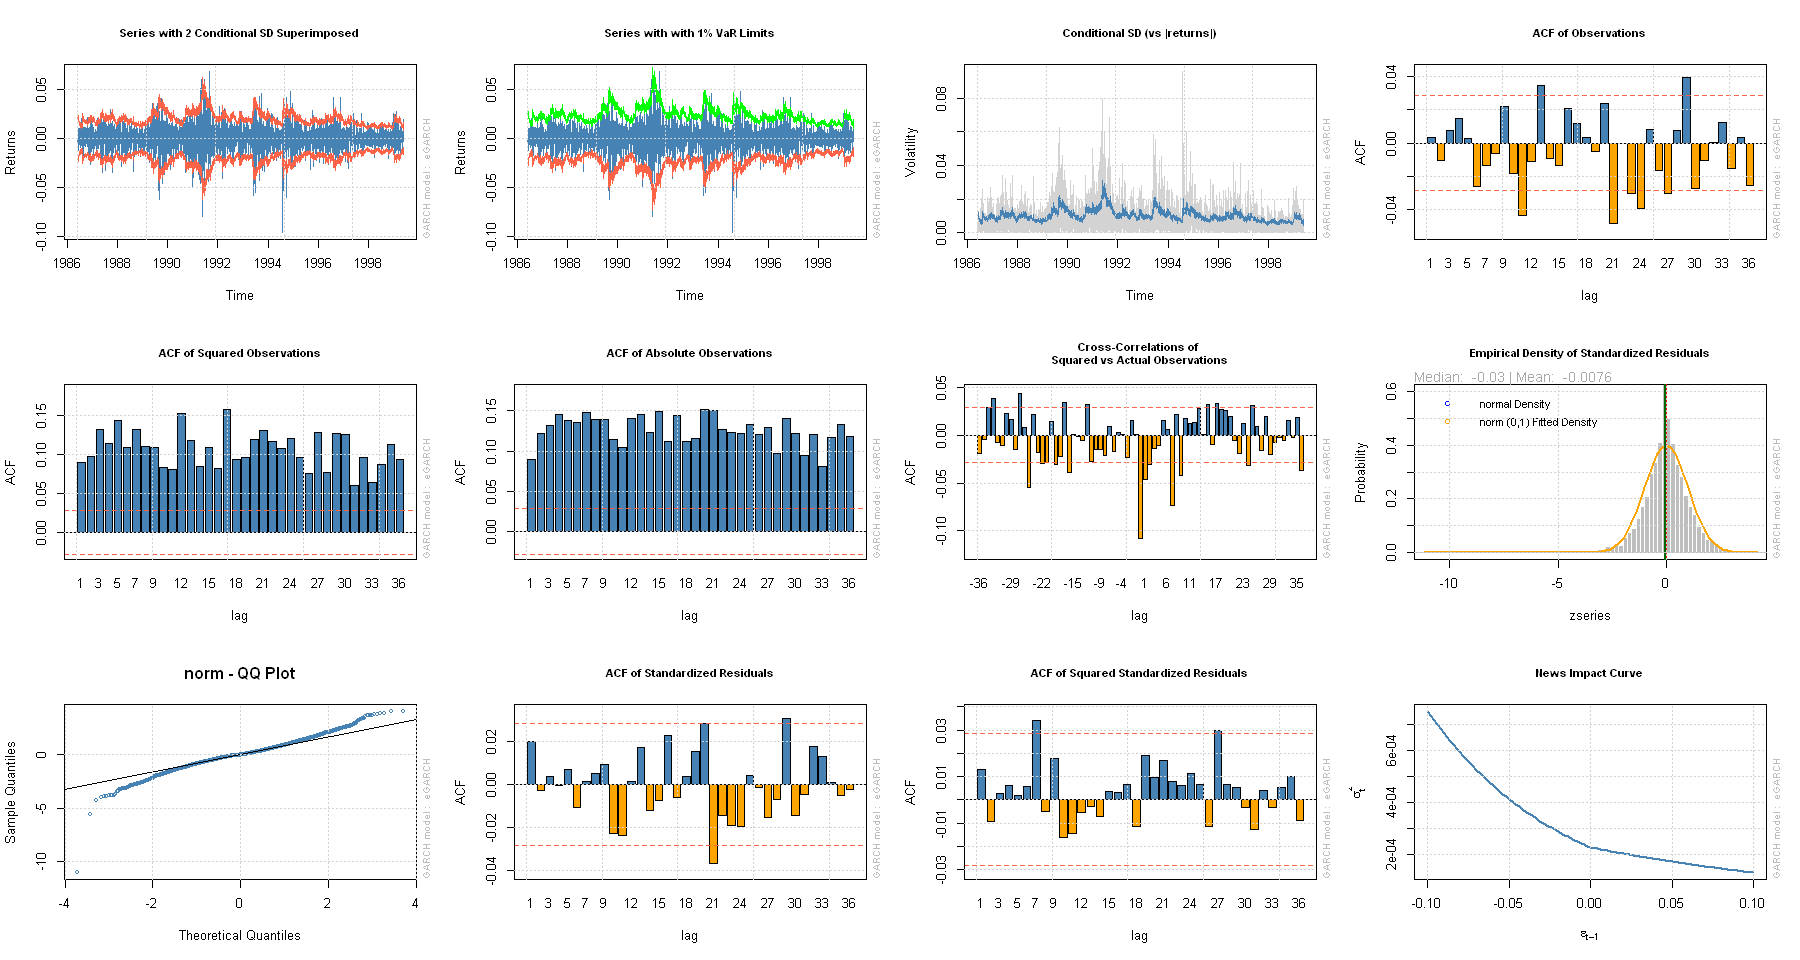

In [44]:
plot(gold_egarch21, which = 'all') 

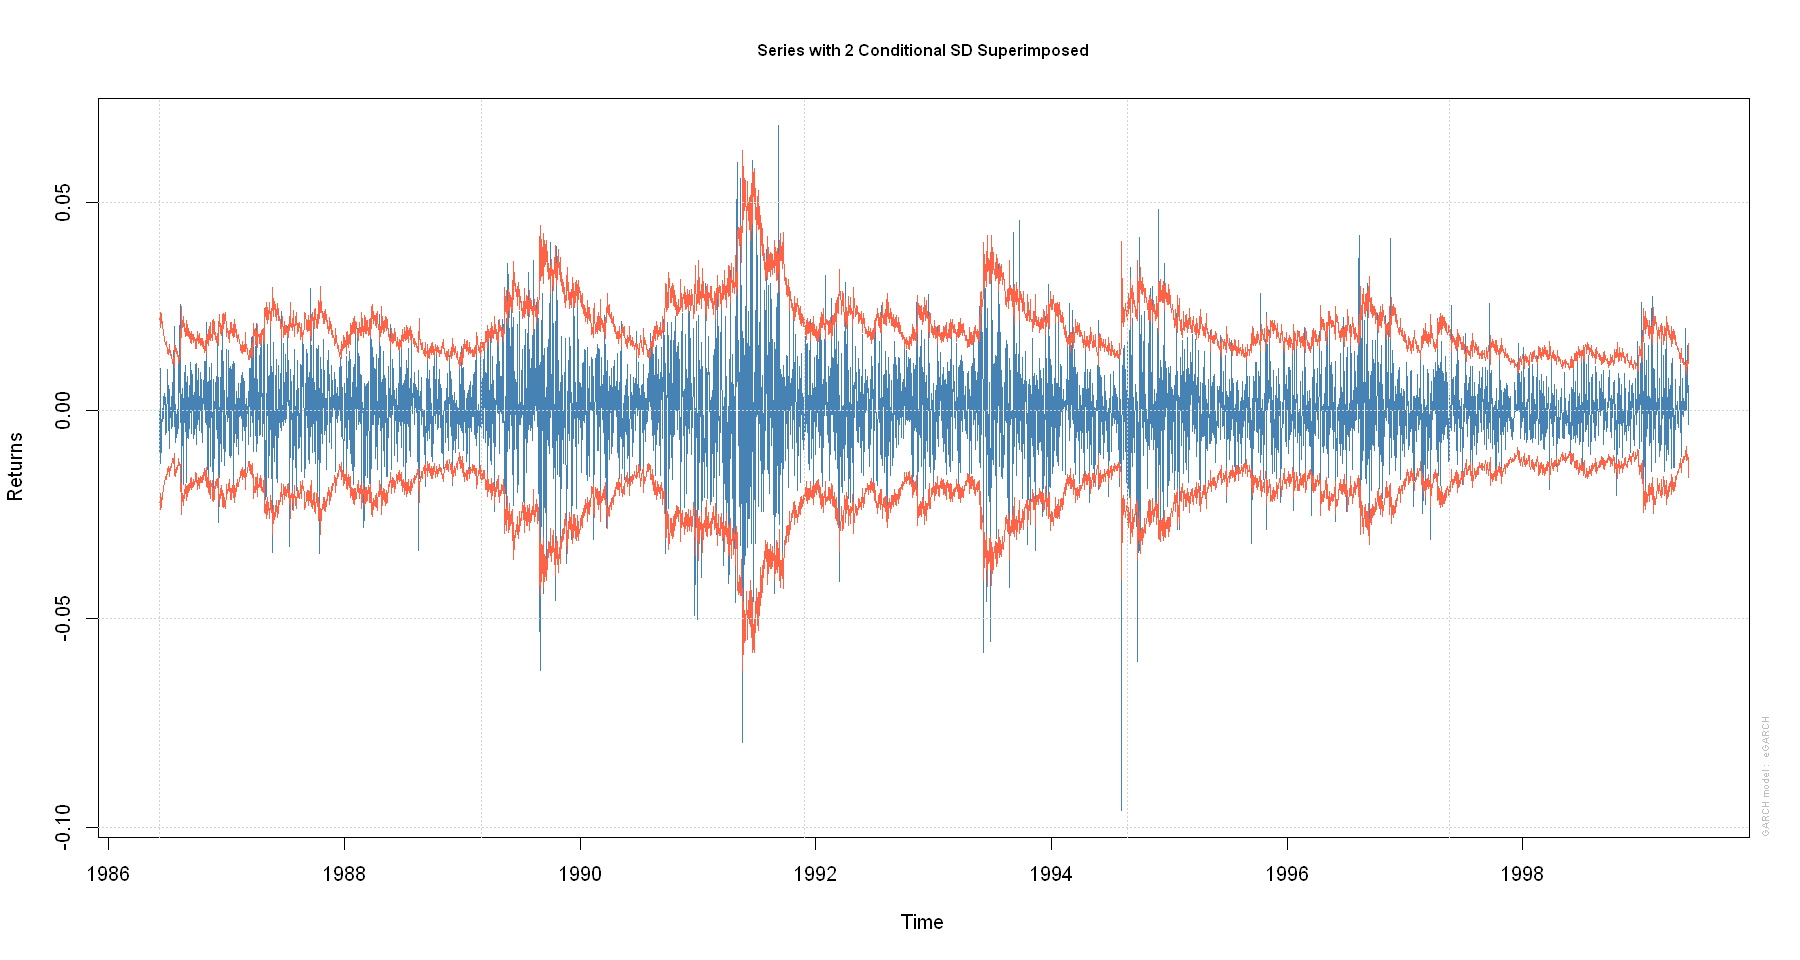

In [45]:
plot(gold_egarch21, which = 1) 

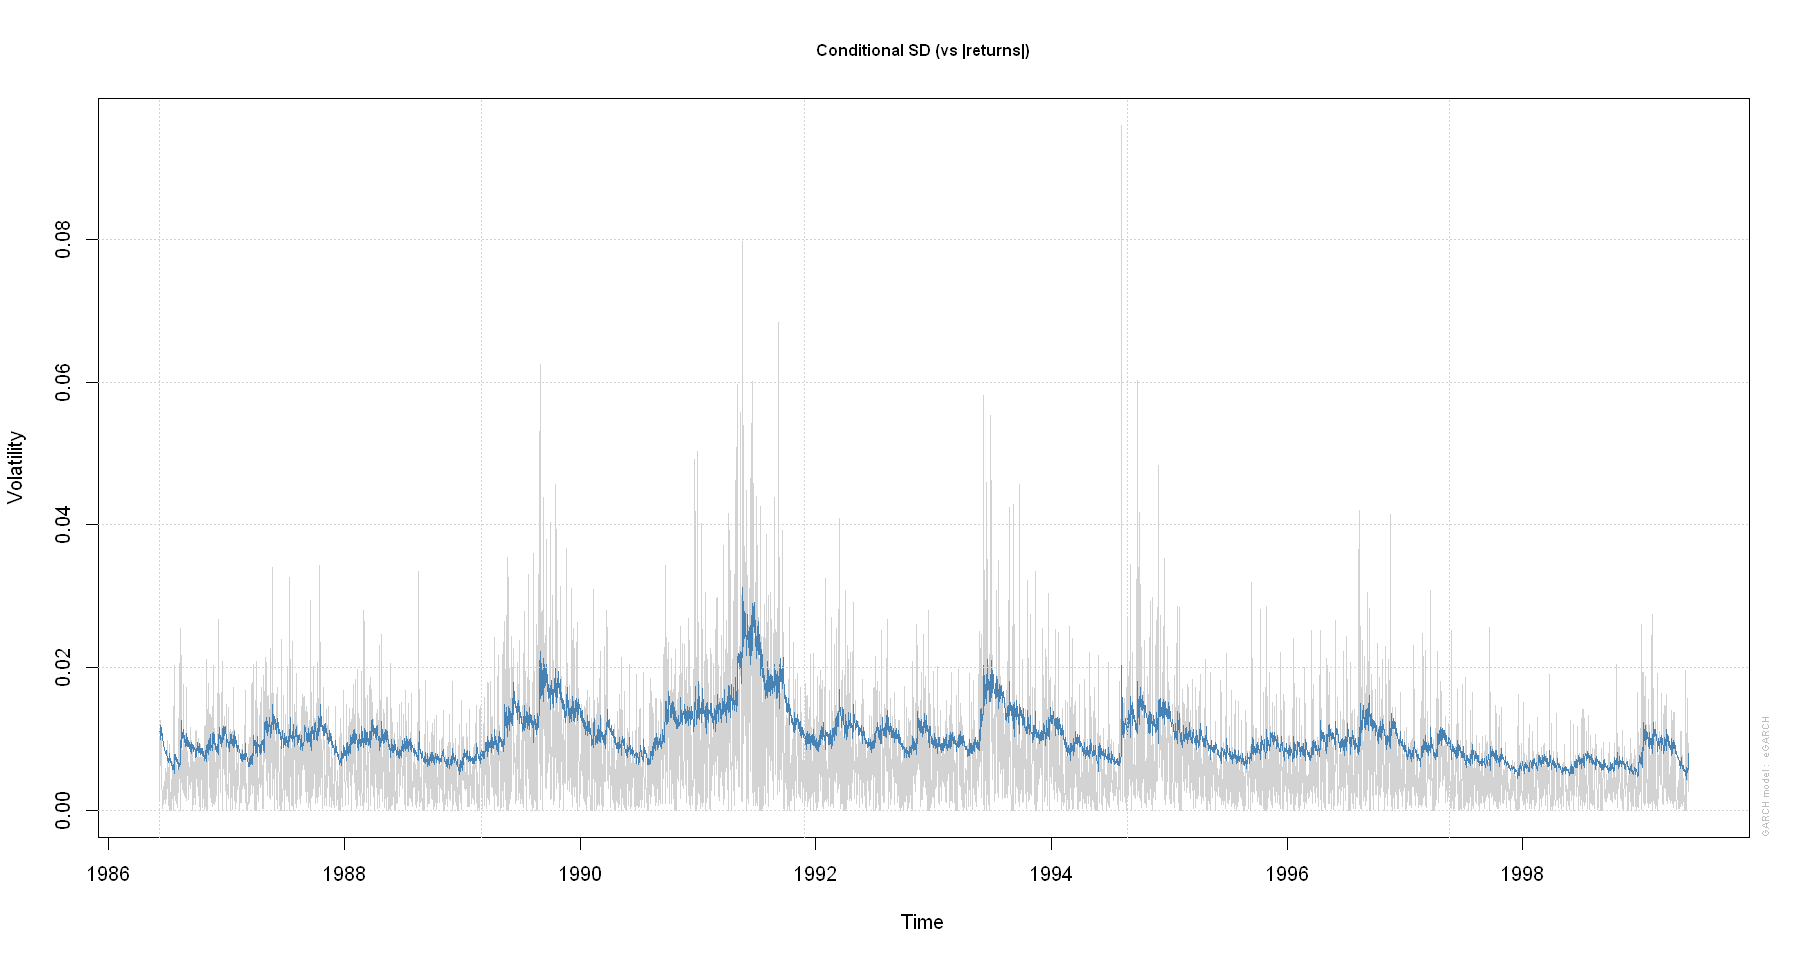

In [46]:
plot(gold_egarch21, which = 3) 

# Prediccion con nuestro mejor modelo EGARCH

In [47]:
predict_gold = ugarchforecast(gold_egarch21,n.ahead = 50)
predict_gold


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: eGARCH
Horizon: 50
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=1999-05-29]:
        Series    Sigma
T+1  0.0005462 0.007401
T+2  0.0005203 0.007487
T+3  0.0005028 0.007527
T+4  0.0004909 0.007568
T+5  0.0004829 0.007608
T+6  0.0004774 0.007648
T+7  0.0004737 0.007688
T+8  0.0004712 0.007728
T+9  0.0004695 0.007768
T+10 0.0004684 0.007808
T+11 0.0004676 0.007848
T+12 0.0004671 0.007888
T+13 0.0004667 0.007927
T+14 0.0004665 0.007967
T+15 0.0004663 0.008006
T+16 0.0004662 0.008045
T+17 0.0004661 0.008084
T+18 0.0004661 0.008124
T+19 0.0004660 0.008162
T+20 0.0004660 0.008201
T+21 0.0004660 0.008240
T+22 0.0004660 0.008279
T+23 0.0004660 0.008317
T+24 0.0004660 0.008355
T+25 0.0004660 0.008394
T+26 0.0004660 0.008432
T+27 0.0004660 0.008470
T+28 0.0004660 0.008508
T+29 0.0004660 0.008546
T+30 0.0004660 0.008583
T+31 0.0004660 0.008621
T+32 0.0004660 0.008658

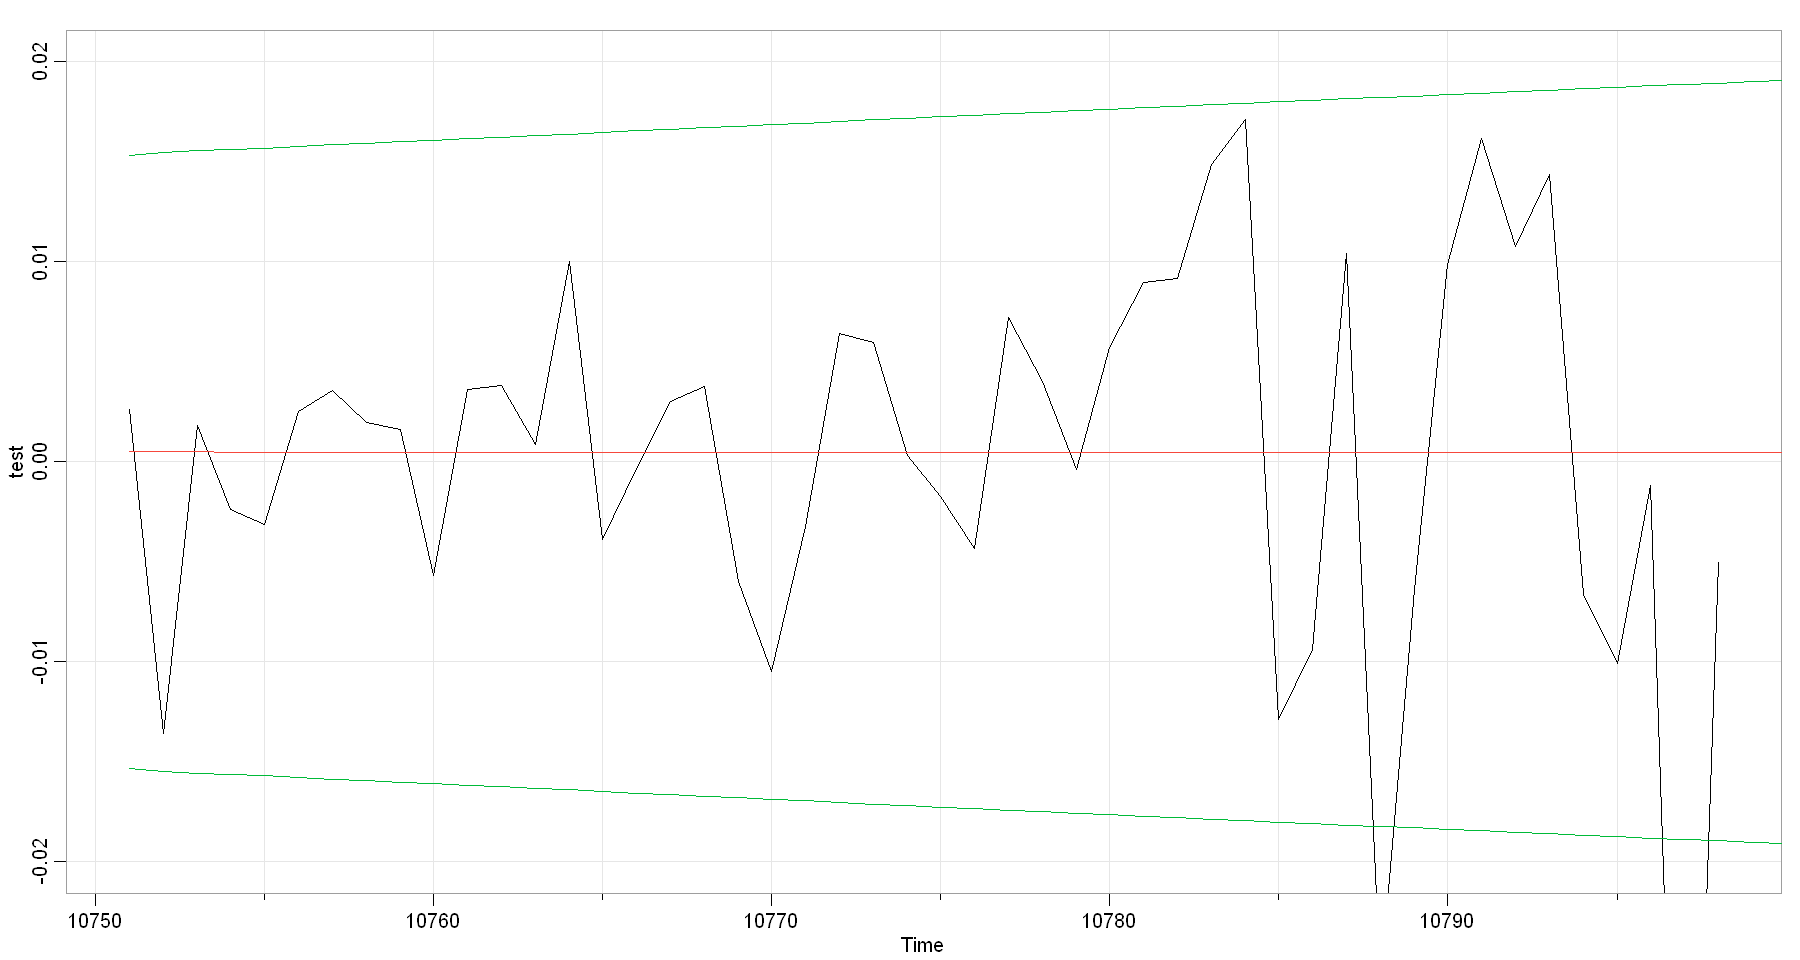

In [48]:
tsplot(test,ylim = c(-0.02,0.02))
lines(ts(predict_gold@forecast$seriesFor,start = 10751),col=2)
lines(ts(predict_gold@forecast$seriesFor + 2*predict_gold@forecast$sigmaFor,start = 10751),col=3)
lines(-ts(predict_gold@forecast$seriesFor + 2*predict_gold@forecast$sigmaFor,start = 10751),col=3)